# Computing distance figures from speeches

This notebooks reads embedded speech vectors and their metadata and computes different distance measures between the speeches

## Imports, methods etc

### Imports

In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from math import log
import os
import pickle
from tqdm import tqdm
import heapq
from scipy.spatial import distance
import random
from scipy import stats
import math

### Setting locations

In [403]:
def data_locations(country_code, topic=None):

    csv_abb = None
    pkl_abb = None
    
    if country_code == 'GB':
        csv_abb = 'GB-commons'
        pkl_abb = 'GB_commons'

    elif country_code in ['HU', 'SI', 'UA']:

        csv_abb = country_code
        pkl_abb = country_code
    
    else:

        raise ValueError('Country code must be one of "GB", "HU", "SI", "UA"')
    

    __location__ = os.path.abspath("")
    sentiment_path = os.path.join(__location__, '..', 'data', 'DHH23_csvs_with_sentiment', 'ParlaMint-' + csv_abb + '_with_sentiment.csv')
    if topic is not None:
        sentiment_path = os.path.join(__location__, '..', 'data', 'topics', topic + '_' + country_code + '.csv')
    speaker_dump_path = os.path.join(__location__, '..', 'data', 'speakers.csv')
    pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_' + pkl_abb + '_embeddings_truncated.pkl'))

    return sentiment_path, speaker_dump_path, pklpath

### Data reading

In [404]:
def read_sentiment_csv(path):
    
    df = pd.read_csv(path)
    return df

In [405]:
def read_embeddings(path):

    with (open(path, "rb")) as openfile:
        while True:
            try:
                embeddings = pickle.load(openfile)
            except EOFError:
                break

    return embeddings

### Filtering and merging dataframes

In [406]:
def set_opposition_and_coalition_gb(df):

    # fill empty party_status with 'Coalition' if party is Conservative
    df.loc[(df['Party_status'].isnull()) & (df['Speaker_party'].str.contains('CON')), 'Party_status'] = 'Coalition'
    # if date is between 2010.05.11 and 2015.05.08, set liberal democrats to coalition
    df.loc[(df['Speaker_party'].str.contains('LD')) & (df['Date_datetime'] >= '2010-05-11') & (df['Date_datetime'] <= '2015-05-08'), 'Party_status'] = 'Coalition'
    # fill empty party_status with 'Opposition'
    df.loc[df['Party_status'].isnull(), 'Party_status'] = 'Opposition'

    return df

In [407]:
def set_bins(df):

    number_of_bins = 10
    if (len(df) // 10000) > 10: 
        number_of_bins = len(df) // 10000
    df.sort_values(by=['Date_datetime'], inplace=True)
    df['bin'] = pd.cut(df['Date_datetime'], bins=number_of_bins, labels=False)

    return df

In [408]:
def filter_df(df, country_code=None):

    # check if Date_datetime column exists
    if 'Date_datetime' not in df.columns:
        df['Date_datetime'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['speech_length'] = df['speech'].apply(lambda x: len(x) if type(x) == str else 0)
    # compute week
    df['week'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.week) if x.week > 9 else '0' + str(x.week)))
    df['month'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.month) if x.month > 9 else '0' + str(x.month)))
    df['quarter'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + str((x.month -1)//3 + 1))
    # #filter out speeches with less than 100 words
    df = df[df['speech_length'] > 200]
    #filter out speeches where the speaker is not a mp
    df = df[df['Speaker_MP'] == 'MP']
    df = df[df['Speaker_role'] == 'Regular']
    # filter data to include only speeches from 2019 onwards
    df = df[df['Date_datetime'] >= '2015-01-01']
    if country_code == 'GB':
        df = set_opposition_and_coalition_gb(df)
    df = set_bins(df)
    #reset index
    df = df.reset_index(drop=True)

    return df

In [409]:
def merge_embeds_and_df(df, embeddings):

    merged_df = df.merge(embeddings, left_on='ID', right_on=embeddings.index, how='inner')

    return merged_df

### Methods for time series analysis

In [418]:
def get_pairwise_distance(embs1, embs2):
    pairwise_distances = []
    for embedding1 in embs1:
        for embedding2 in embs2:
            pairwise_distances.append(distance.cosine(embedding1, embedding2))
    return np.mean(pairwise_distances)


def get_distance_from_samples(emb1, emb2, sample_sz=100, tries=1000):

    party1 = [embedding for embedding in emb1]
    party2 = [embedding for embedding in emb2]

    sample_distances = []
    sample_distances_party1 = []
    sample_distances_party2 = []
    for i in range(tries):
        sample_distances.append(
            get_pairwise_distance(
                random.sample(party1, sample_sz),
                random.sample(party2, sample_sz),
            )
        )
        sample_distances_party1.append(
            get_pairwise_distance(
                random.sample(party1, sample_sz),
                random.sample(party1, sample_sz),
            )
        )
        sample_distances_party2.append(
            get_pairwise_distance(
                random.sample(party2, sample_sz),
                random.sample(party2, sample_sz),
            )
        )

    # calculate mean
    mean = np.mean(sample_distances)
    meanp1 = np.mean(sample_distances_party1)
    meanp2 = np.mean(sample_distances_party2)

    # calculate standard deviation
    std_dev = np.std(sample_distances)
    std_devp1 = np.std(sample_distances_party1)
    std_devp2 = np.std(sample_distances_party2)

    # calculate standard error
    std_err = std_dev / np.sqrt(len(sample_distances))
    std_errp1 = std_devp1 / np.sqrt(len(sample_distances_party1))
    std_errp2 = std_devp2 / np.sqrt(len(sample_distances_party2))

    # calculate confidence interval (default to 95% confidence)
    confidence = 0.95
    ci = stats.norm.interval(confidence, loc=mean, scale=std_err)
    cip1 = stats.norm.interval(confidence, loc=meanp1, scale=std_errp1)
    cip2 = stats.norm.interval(confidence, loc=meanp2, scale=std_errp2)

    return mean, ci, meanp1, cip1, meanp2, cip2
    # return mean, std_err

In [411]:
def new_analysis_df():

    return pd.DataFrame(columns=['time_period', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches', 'sentiment'])

def new_opp_coal_df():

    return pd.DataFrame(columns=['time_period', 'average_opp_sentiment', 'average_coal_sentiment', 'mean', 'cil', 'cih', 'mean1', 'cil1', 'cih1', 'mean2', 'cil2', 'cih2', 'n', 'number_of_opp_speeches', 'number_of_coal_speeches'])

def new_speakers_df():

    return pd.DataFrame(columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])

def sliced_data(time_period_type, time_period, df):

    df_p = df[df[time_period_type] == time_period]
    vectors_p = df_p['embeddings'].values
    vectors_p = np.array([np.array(x) for x in vectors_p])

    return df_p, vectors_p

def party_figures(df, speech_mean_vector, speech_median_vector):

    parties = df['Speaker_party'].unique()
    #remove null party
    parties = [p for p in parties if str(p) != 'nan']
    #calculate mean vector for each party
    party_mean_vectors = []
    party_median_vectors = []
    trivial_parties = []
    for p in parties:
        #filter vectors to only include vectors where speaker party is p
        vectors_p = df[df['Speaker_party'] == p]['embeddings'].values
        if (len(vectors_p) / len(df)) < 0.1:
            trivial_parties.append(p)
            continue
        vectors_p = np.array([np.array(x) for x in vectors_p])
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        party_mean_vectors.append(mean_vector_p)
        #calculate median vector for party p
        median_vector_p = np.median(vectors_p, axis=0)
        party_median_vectors.append(median_vector_p)
    #remove trivial parties
    for p in trivial_parties:
        parties.remove(p)
    #compute party weights
    party_weights = np.array([len(df[df['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_p - speech_mean_vector) for mean_vector_p in party_mean_vectors])
    party_distances = party_distances @ party_weights.T
    mean_weighted_party_distance = np.mean(party_distances)
    #compute party vector distances to median vector
    party_distances_median = np.array([np.linalg.norm(median_vector_p - speech_median_vector) for median_vector_p in party_median_vectors])
    median_party_distance = np.median(party_distances_median)

    return mean_weighted_party_distance, median_party_distance

def speaker_figures(df, time_period, speech_mean_vector, speech_median_vector):

    #list distinct speakers in df_w
    speakers = df['Speaker_name'].unique()
    #new dataframe for speaker monthly stats
    speakers_monthly_stats = new_speakers_df()
    #calculate mean vector for each speaker
    speaker_mean_vectors = []
    speaker_median_vectors = []
    for s in speakers:
        #filter vectors to only include vectors where speaker is s
        vectors_s = df[df['Speaker_name'] == s]['embeddings'].values
        vectors_s = np.array([np.array(x) for x in vectors_s])
        #calculate mean vector for speaker s
        mean_vector_s = np.mean(vectors_s, axis=0)
        speaker_mean_vectors.append(mean_vector_s)
        #calculate median vector for speaker s
        median_vector_s = np.median(vectors_s, axis=0)
        speaker_median_vectors.append(median_vector_s)
        #add speaker to df_speakers
        speaker_row = pd.DataFrame([[s, time_period, np.linalg.norm(mean_vector_s - speech_mean_vector), len(vectors_s)]], columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])
        speakers_monthly_stats = pd.concat([speakers_monthly_stats, speaker_row])
    #compute speaker weights
    speaker_weights = np.array([len(df[df['Speaker_name'] == s]) for s in speakers])
    speaker_weights = speaker_weights / np.sum(speaker_weights)
    #compute speaker vector distances to mean vector
    speaker_distances = np.array([np.linalg.norm(mean_vector_s - speech_mean_vector) for mean_vector_s in speaker_mean_vectors])
    speaker_distances = speaker_distances @ speaker_weights.T
    speaker_mean_distance = np.sum(speaker_distances)
    #compute speaker vector distances to median vector
    speaker_distances_median = np.array([np.linalg.norm(median_vector_s - speech_median_vector) for median_vector_s in speaker_median_vectors])
    speaker_median_distance = np.median(speaker_distances_median)

    return speaker_mean_distance, speaker_median_distance, speakers_monthly_stats

def cosine_similarities(speech_vectors, speech_mean_vector, speech_median_vector):

    #calculate cosine similarities
    
    monthly_cos_sim_to_mean = cosine_similarity(speech_vectors, speech_mean_vector.reshape(1, -1))
    monthly_cos_sim_m_to_median = cosine_similarity(speech_vectors, speech_median_vector.reshape(1, -1))
    #calculate mean and median cosine similarities
    mean_cos_sim = np.mean(monthly_cos_sim_to_mean)
    median_cos_sim = np.median(monthly_cos_sim_m_to_median)
    
    return mean_cos_sim, median_cos_sim

def top_bottom_distance(party1, party2):

    max1 = np.argmax(np.abs(party1), axis=0)
    max2 = np.argmax(np.abs(party2), axis=0)
    party1_max = []
    party2_max = []
    for i in range(len(max1)):
        party1_max.append(party1[max1[i]][i])
        party2_max.append(party2[max2[i]][i])
    return distance.euclidean(party1_max, party2_max)

def opposition_coalition_figures(df):

    dfopp = df[df['Party_status'] == 'Opposition']
    dfcoal = df[df['Party_status'] == 'Coalition']
    if len(dfopp) < 5 or len(dfcoal) < 5:
        return None, None, None, None, None, None, None
    #calculate mean vector for opposition
    vectors_opp = dfopp['embeddings'].values
    # vectors_opp = np.array([np.array(x) for x in vectors_opp])
    # vectors_opp = np.nan_to_num(vectors_opp, copy=True, nan=0.0)
    # mean_vector_opp = np.mean(vectors_opp, axis=0)
    #calculate mean vector for coalition
    vectors_coal = dfcoal['embeddings'].values
    # vectors_coal = np.array([np.array(x) for x in vectors_coal])
    # mean_vector_coal = np.mean(vectors_coal, axis=0)

    number_of_opp_speeches = len(dfopp)
    number_of_coal_speeches = len(dfcoal)

    n = 100
    tries = 30
    if n > 0.5 * min(len(vectors_opp), len(vectors_coal)):
        n = math.floor(0.5 * min(len(vectors_opp), len(vectors_coal)))
    mean, ci, mean1, ci1, mean2, ci2 = get_distance_from_samples(emb1=vectors_opp, emb2=vectors_coal, sample_sz=n, tries=tries)

    average_opp_sentiment = np.mean(dfopp['sentiment'])
    average_coal_sentiment = np.mean(dfcoal['sentiment'])
    # distance = np.linalg.norm(mean_vector_opp - mean_vector_coal)
    # similarity = cosine_similarity(mean_vector_opp.reshape(1, -1), mean_vector_coal.reshape(1, -1))
    
    return average_opp_sentiment, average_coal_sentiment, mean, ci, mean1, ci1, mean2, ci2, n, number_of_opp_speeches, number_of_coal_speeches

def sentiment(df):

    return np.mean(df['sentiment']), np.median(df['sentiment'])

### Main loop

In [412]:
def analysis(time_period_type, mergeddf):
    
    if time_period_type not in ['month', 'year', 'quarter', 'bin']:
        raise ValueError('time_period_type must be one of "month", "year", "quarter", "bin"')

    time_periods = mergeddf[time_period_type].unique()

    
    #initialize dfs for storing results
    span_means = new_analysis_df()
    span_medians = new_analysis_df()
    span_opp_coal = new_opp_coal_df()
    df_speakers = new_speakers_df()

    #iterate over time periods
    for tp in tqdm(time_periods):
        #filter df to only include speeches in time period tp
        df_tp, vectors_tp = sliced_data(time_period_type=time_period_type, time_period=tp, df=mergeddf)
        number_of_speeches = len(df_tp)
        
        #calculate mean, median vector for month m
        # mean_vector_tp = np.mean(vectors_tp, axis=0)
        # median_vector_tp = np.median(vectors_tp, axis=0)
        
        #calculate mean, median distances for parties, speakers
        # weighted_mean_party_distance, median_party_distance = party_figures(df=df_tp, speech_mean_vector=mean_vector_tp, speech_median_vector=median_vector_tp)
        # weighted_mean_speaker_distance, median_speaker_distance, speakers_monthly_stats = speaker_figures(df=df_tp, time_period=tp, speech_mean_vector=mean_vector_tp, speech_median_vector=median_vector_tp)
        # df_speakers = pd.concat([df_speakers, speakers_monthly_stats])
        
        #compute mean cosine similarity for month m
        # mean_cos_sim, median_cos_sim = cosine_similarities(speech_vectors=vectors_tp, speech_mean_vector=mean_vector_tp, speech_median_vector=median_vector_tp)

        #compute mean, median sentiment for month m
        # mean_sentiment, median_sentiment = sentiment(df_tp)

        #concatenate monthly means
        # monthly_mean_row = pd.DataFrame([[tp, mean_cos_sim, weighted_mean_party_distance, weighted_mean_speaker_distance, number_of_speeches, mean_sentiment]], columns=span_means.columns)
        # span_means = pd.concat([span_means, monthly_mean_row])
        
        #concatenate monthly medians
        # monthly_median_row = pd.DataFrame([[tp, median_cos_sim, median_party_distance, median_speaker_distance, number_of_speeches, median_sentiment]], columns=span_medians.columns)
        # span_medians = pd.concat([span_medians, monthly_median_row])

        #concatenate monthly opposition coalition figures
        average_opp_sentiment, average_coal_sentiment, mean, ci, mean1, ci1, mean2, ci2, n, number_of_opp_speeches, number_of_coal_speeches = opposition_coalition_figures(df=df_tp)
        if average_opp_sentiment is None:
            continue
        tp_value = tp
        if time_period_type == 'bin':
            tp_value = df_tp.iloc[0]['Date_datetime']
        cil = ci[0]
        cih = ci[1]
        cil1 = ci1[0]
        cih1 = ci1[1]
        cil2 = ci2[0]
        cih2 = ci2[1]
        opp_coal_row = pd.DataFrame([[tp_value, average_opp_sentiment, average_coal_sentiment, mean, cil, cih, mean1, cil1, cih1, mean2, cil2, cih2, n, number_of_opp_speeches, number_of_coal_speeches]], columns=span_opp_coal.columns)
        span_opp_coal = pd.concat([span_opp_coal, opp_coal_row])

    df_speakers['monthly_mean_distance'] = df_speakers['monthly_distance'] / df_speakers['number_of_speeches']

    # return span_means, span_medians, df_speakers, span_opp_coal
    return span_opp_coal
    

### Plots

#### Mean, median

In [413]:
def plot_time_series(df, party_distance, speaker_distance, time_period_type):

    df_time_span = df.sort_values(by=['time_period']).reset_index(drop=True)
    df_time_span['party_distance_norm'] = df_time_span['party_distance'] / np.max(df_time_span['party_distance'])
    df_time_span['speaker_distance_norm'] = df_time_span['speaker_distance'] / np.max(df_time_span['speaker_distance'])

    fig, ax1 = plt.subplots(figsize=(40, 24))
    ax2 = ax1.twinx()

    ax1.plot(df_time_span['time_period'], df_time_span['cos_sim'], linewidth=3)
    if(speaker_distance):
        ax1.plot(df_time_span['time_period'], df_time_span['speaker_distance_norm'], linewidth=3)
    ax1.plot(df_time_span['time_period'], df_time_span['sentiment'], linewidth=3, color='red')
    ax2.bar(df_time_span['time_period'], df_time_span['number_of_speeches'], alpha=0.3)
    if(party_distance):
        ax1.plot(df_time_span['time_period'], df_time_span['party_distance_norm'], linewidth=3)
    fig.autofmt_xdate()
    ax1.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
    labels = ['Cosine similarity'] 
    if(speaker_distance):
        labels.append('Speaker distance')
    labels.append('Sentiment')
    if(party_distance):
        labels.append('Party distance')
    ax1.legend(labels = labels, loc='upper left', fontsize=30)
    ax2.legend(labels = ['Number of speeches'], loc='upper right', fontsize=30)
    #set title
    if(time_period_type == 'month'):
        ax1.set_title('Monthly analysis', fontsize=40)
    elif(time_period_type == 'quarter'):
        ax1.set_title('Quarterly analysis', fontsize=40)
    elif(time_period_type == 'year'):
        ax1.set_title('Yearly analysis', fontsize=40)
    plt.show()

#### Opposition-coalition

In [414]:
def plot_opposition_coalition_time_series(df, time_period_type, country, topic=None, save_path=None, show_plot=True):

    df_time_span = df.sort_values(by=['time_period']).reset_index(drop=True)
    df_time_span['number_of_speeches'] = df_time_span['number_of_opp_speeches'] + df_time_span['number_of_coal_speeches']
    df_time_span['1-mean'] = 1 - df_time_span['mean']
    df_time_span['1-cil'] = 1 - df_time_span['cil']
    df_time_span['1-cih'] = 1 - df_time_span['cih']
    df_time_span['1-mean1'] = 1 - df_time_span['mean1']
    df_time_span['1-cil1'] = 1 - df_time_span['cil1']
    df_time_span['1-cih1'] = 1 - df_time_span['cih1']
    df_time_span['1-mean2'] = 1 - df_time_span['mean2']
    df_time_span['1-cil2'] = 1 - df_time_span['cil2']
    df_time_span['1-cih2'] = 1 - df_time_span['cih2']
    df_time_span['avg_sentiment'] = (df_time_span['average_opp_sentiment'] * df_time_span['number_of_opp_speeches'] + df_time_span['average_coal_sentiment'] * df_time_span['number_of_coal_speeches']) / (df_time_span['number_of_speeches'])
    colors = ['#F35611', '#E79E4B', '#DDC08C', '#4BB8BD', '#5251BB']

    fig, ax1 = plt.subplots(figsize=(40, 24))
    ax2 = ax1.twinx()

    # ax1.plot(df_time_span['time_period'], df_time_span['avg_sentiment'], linewidth=5, color=colors[0])
    ax1.plot(df_time_span['time_period'], df_time_span['1-mean'], linewidth=5, color=colors[-1])
    ax1.plot(df_time_span['time_period'], df_time_span['1-mean1'], linewidth=5, color=colors[-2])
    ax1.plot(df_time_span['time_period'], df_time_span['1-mean2'], linewidth=5, color=colors[-3])
    # ax1.plot(df_time_span['time_period'], df_time_span['cil'], linewidth=3, color='green')
    # ax1.plot(df_time_span['time_period'], df_time_span['cih'], linewidth=3, color='green')
    ax1.fill_between(df_time_span['time_period'], df_time_span['1-cil'], df_time_span['1-cih'], color=colors[-1], alpha=0.3)
    ax1.fill_between(df_time_span['time_period'], df_time_span['1-cil1'], df_time_span['1-cih1'], color=colors[-2], alpha=0.3)
    ax1.fill_between(df_time_span['time_period'], df_time_span['1-cil2'], df_time_span['1-cih2'], color=colors[-3], alpha=0.3)

    ax2.bar(df_time_span['time_period'], df_time_span['number_of_speeches'], color=colors[-2], alpha=0.3)
    # ax2.bar(df_time_span['time_period'], df_time_span['number_of_opp_speeches'], color=colors[2], alpha=0.3)
    # ax2.bar(df_time_span['time_period'], df_time_span['number_of_coal_speeches'], bottom=df_time_span['number_of_opp_speeches'], color=colors[2], alpha=0.3)

    ax1.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
    labels1 = ['Avg. Sentiment', 'Sample Mean Difference']
    labels2 = ['Number of Speeches']
    # ax1.legend(labels = labels1, loc='upper left', fontsize=30)
    # ax2.legend(labels = labels2, loc='upper right', fontsize=30)
    fig.autofmt_xdate()
    plt.rcParams.update({'font.size': 22})
    # ax1.tick_params(axis='both', which='major', labelsize=10)
    # ax1.tick_params(axis='both', which='minor', labelsize=8)
    # # ax2.tick_params(axis='y', which='major', labelsize=10)
    # # ax2.tick_params(axis='y', which='minor', labelsize=8)
    #set title
    if topic is None:
        topic = 'complete data'
    if(time_period_type == 'month'):
        ax1.set_title('Monthly, ' + country + ' ' + topic, fontsize=40)
    elif(time_period_type == 'quarter'):
        ax1.set_title('Quarterly, ' + country + ' ' + topic, fontsize=40)
    elif(time_period_type == 'year'):
        ax1.set_title('Yearly, ' + country + ' ' + topic, fontsize=40)
    if(save_path != None):
        plt.savefig(save_path)
    if(show_plot):
        plt.show()

### Read data and run analysis for a country

In [415]:
def run_analysis(country, time_period, topic=None, df=None, df_embeddings=None):

    __location__ = os.path.abspath("")
    sentiment_path, speaker_dump_path, pklpath = data_locations(country, topic)
    if df is None:
        df = read_sentiment_csv(sentiment_path)
        df = filter_df(df, country)

    if df_embeddings is None:
        embeddings = read_embeddings(pklpath)
        df_embeddings = pd.DataFrame(index=embeddings.keys())
        df_embeddings['embeddings'] = embeddings.values()
    mergeddf = merge_embeds_and_df(df, df_embeddings)

    csv_path = os.path.join(__location__, '..', 'data', 'time_series', 'csv', country + '_complete_data' + '.csv')
    png_path = os.path.join(__location__, '..', 'data', 'time_series', 'png', country + '_complete_data' + '.png')
    if topic is not None:
        csv_path = os.path.join(__location__, '..', 'data', 'time_series', 'csv', country + '_' + topic + '.csv')
        png_path = os.path.join(__location__, '..', 'data', 'time_series', 'png', country + '_' + topic + '.png')

    span_opp_coal = analysis(time_period_type=time_period, mergeddf=mergeddf)
    plot_opposition_coalition_time_series(df=span_opp_coal, time_period_type=time_period, country=country, topic=topic, save_path=png_path, show_plot=False)
    span_opp_coal.to_csv(csv_path, index=False)

    return df, df_embeddings, mergeddf, span_opp_coal
    
    
    

## Running the Analysis

In [354]:
sentiment_path, speaker_dump_path, pklpath = data_locations('GB', 'eu')
df = read_sentiment_csv(sentiment_path)
df = filter_df(df, 'GB')
embeddings = read_embeddings(pklpath)
df_emb = pd.DataFrame(index=embeddings.keys())
df_emb['embeddings'] = embeddings.values()
df_merg = merge_embeds_and_df(df, df_emb)
print(df_merg.columns)

Index(['ID', 'Title', 'Date', 'Body', 'Term', 'Session', 'Meeting', 'Sitting',
       'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_MP', 'Speaker_Minister',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', 'speech', 'speech_split',
       'sentiment', 'speech_length', 'Date_datetime', 'week', 'month',
       'quarter', 'bin', 'embeddings'],
      dtype='object')


In [355]:
df_merg_q1 = df_merg[df_merg['quarter'] == '2020-1']
df_merg_q1.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,speech,speech_split,sentiment,speech_length,Date_datetime,week,month,quarter,bin,embeddings
30587,ParlaMint-GB_2020-01-07-commons.u289,"Minutes of the House of Commons, Daily Session...",2020-01-07,Lower house,58,NaN,NaN,2020-01-07,NaN,Reference,...,I had hoped for a better initial intervention....,We are very clear that we accept that the gen...,0.531738,807,2020-01-07,2020-02,2020-01,2020-1,6,"[-0.055136897, -0.006318393, -0.005610155, -0...."
30588,ParlaMint-GB_2020-01-07-commons.u293,"Minutes of the House of Commons, Daily Session...",2020-01-07,Lower house,58,NaN,NaN,2020-01-07,NaN,Reference,...,I am always happy to confirm what is on the pu...,We believe that there would have been the pos...,0.065430,1417,2020-01-07,2020-02,2020-01,2020-1,6,"[-0.119326636, -0.015572308, -0.00571569, -0.0..."
30589,ParlaMint-GB_2020-01-07-commons.u296,"Minutes of the House of Commons, Daily Session...",2020-01-07,Lower house,58,NaN,NaN,2020-01-07,NaN,Reference,...,"My hon. Friend is making an excellent speech, ...","Friend is making an excellent speech, the ton...",-0.711914,776,2020-01-07,2020-02,2020-01,2020-1,6,"[-0.05520862, 0.011720585, -0.0054060463, 0.06..."
30590,ParlaMint-GB_2020-01-07-commons.u300,"Minutes of the House of Commons, Daily Session...",2020-01-07,Lower house,58,NaN,NaN,2020-01-07,NaN,Reference,...,Does the hon. Gentleman accept that for many p...,NaN,-0.216431,321,2020-01-07,2020-02,2020-01,2020-1,6,"[-0.024141656, -0.046631463, -0.004462994, 0.0..."
30591,ParlaMint-GB_2020-01-07-commons.u301,"Minutes of the House of Commons, Daily Session...",2020-01-07,Lower house,58,NaN,NaN,2020-01-07,NaN,Reference,...,I thank the right hon. Gentleman for that inte...,"Gentleman for that intervention, because it g...",-0.580566,2895,2020-01-07,2020-02,2020-01,2020-1,6,"[-0.06656869, -0.08664197, -0.0060848817, 0.01..."


In [356]:
def_opp = df_merg_q1[df_merg_q1['Party_status'] == 'Opposition']
def_coal = df_merg_q1[df_merg_q1['Party_status'] == 'Coalition']

In [376]:
opposition = def_opp['embeddings'].values
coalition = def_coal['embeddings'].values

# party1 = [embedding for embedding in opposition]

# print(type(party1[0]))

mean, stderr = get_distance_from_samples(opposition, coalition, 20, 30)
print(mean, stderr)

AttributeError: 'DataFrame' object has no attribute 'norm'

### Individual Run

In [384]:
df, df_embeddings, mergeddf, stats1 = run_analysis(country='GB', time_period='quarter', topic='eu')

 19%|█▉        | 6/31 [00:25<01:45,  4.23s/it]


KeyboardInterrupt: 

In [339]:
df, df_embeddings, dfc, stats1 = run_analysis(country='GB', time_period='quarter', topic='eu', df=df, df_embeddings=df_embeddings)

  0%|          | 0/31 [00:05<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'norm'

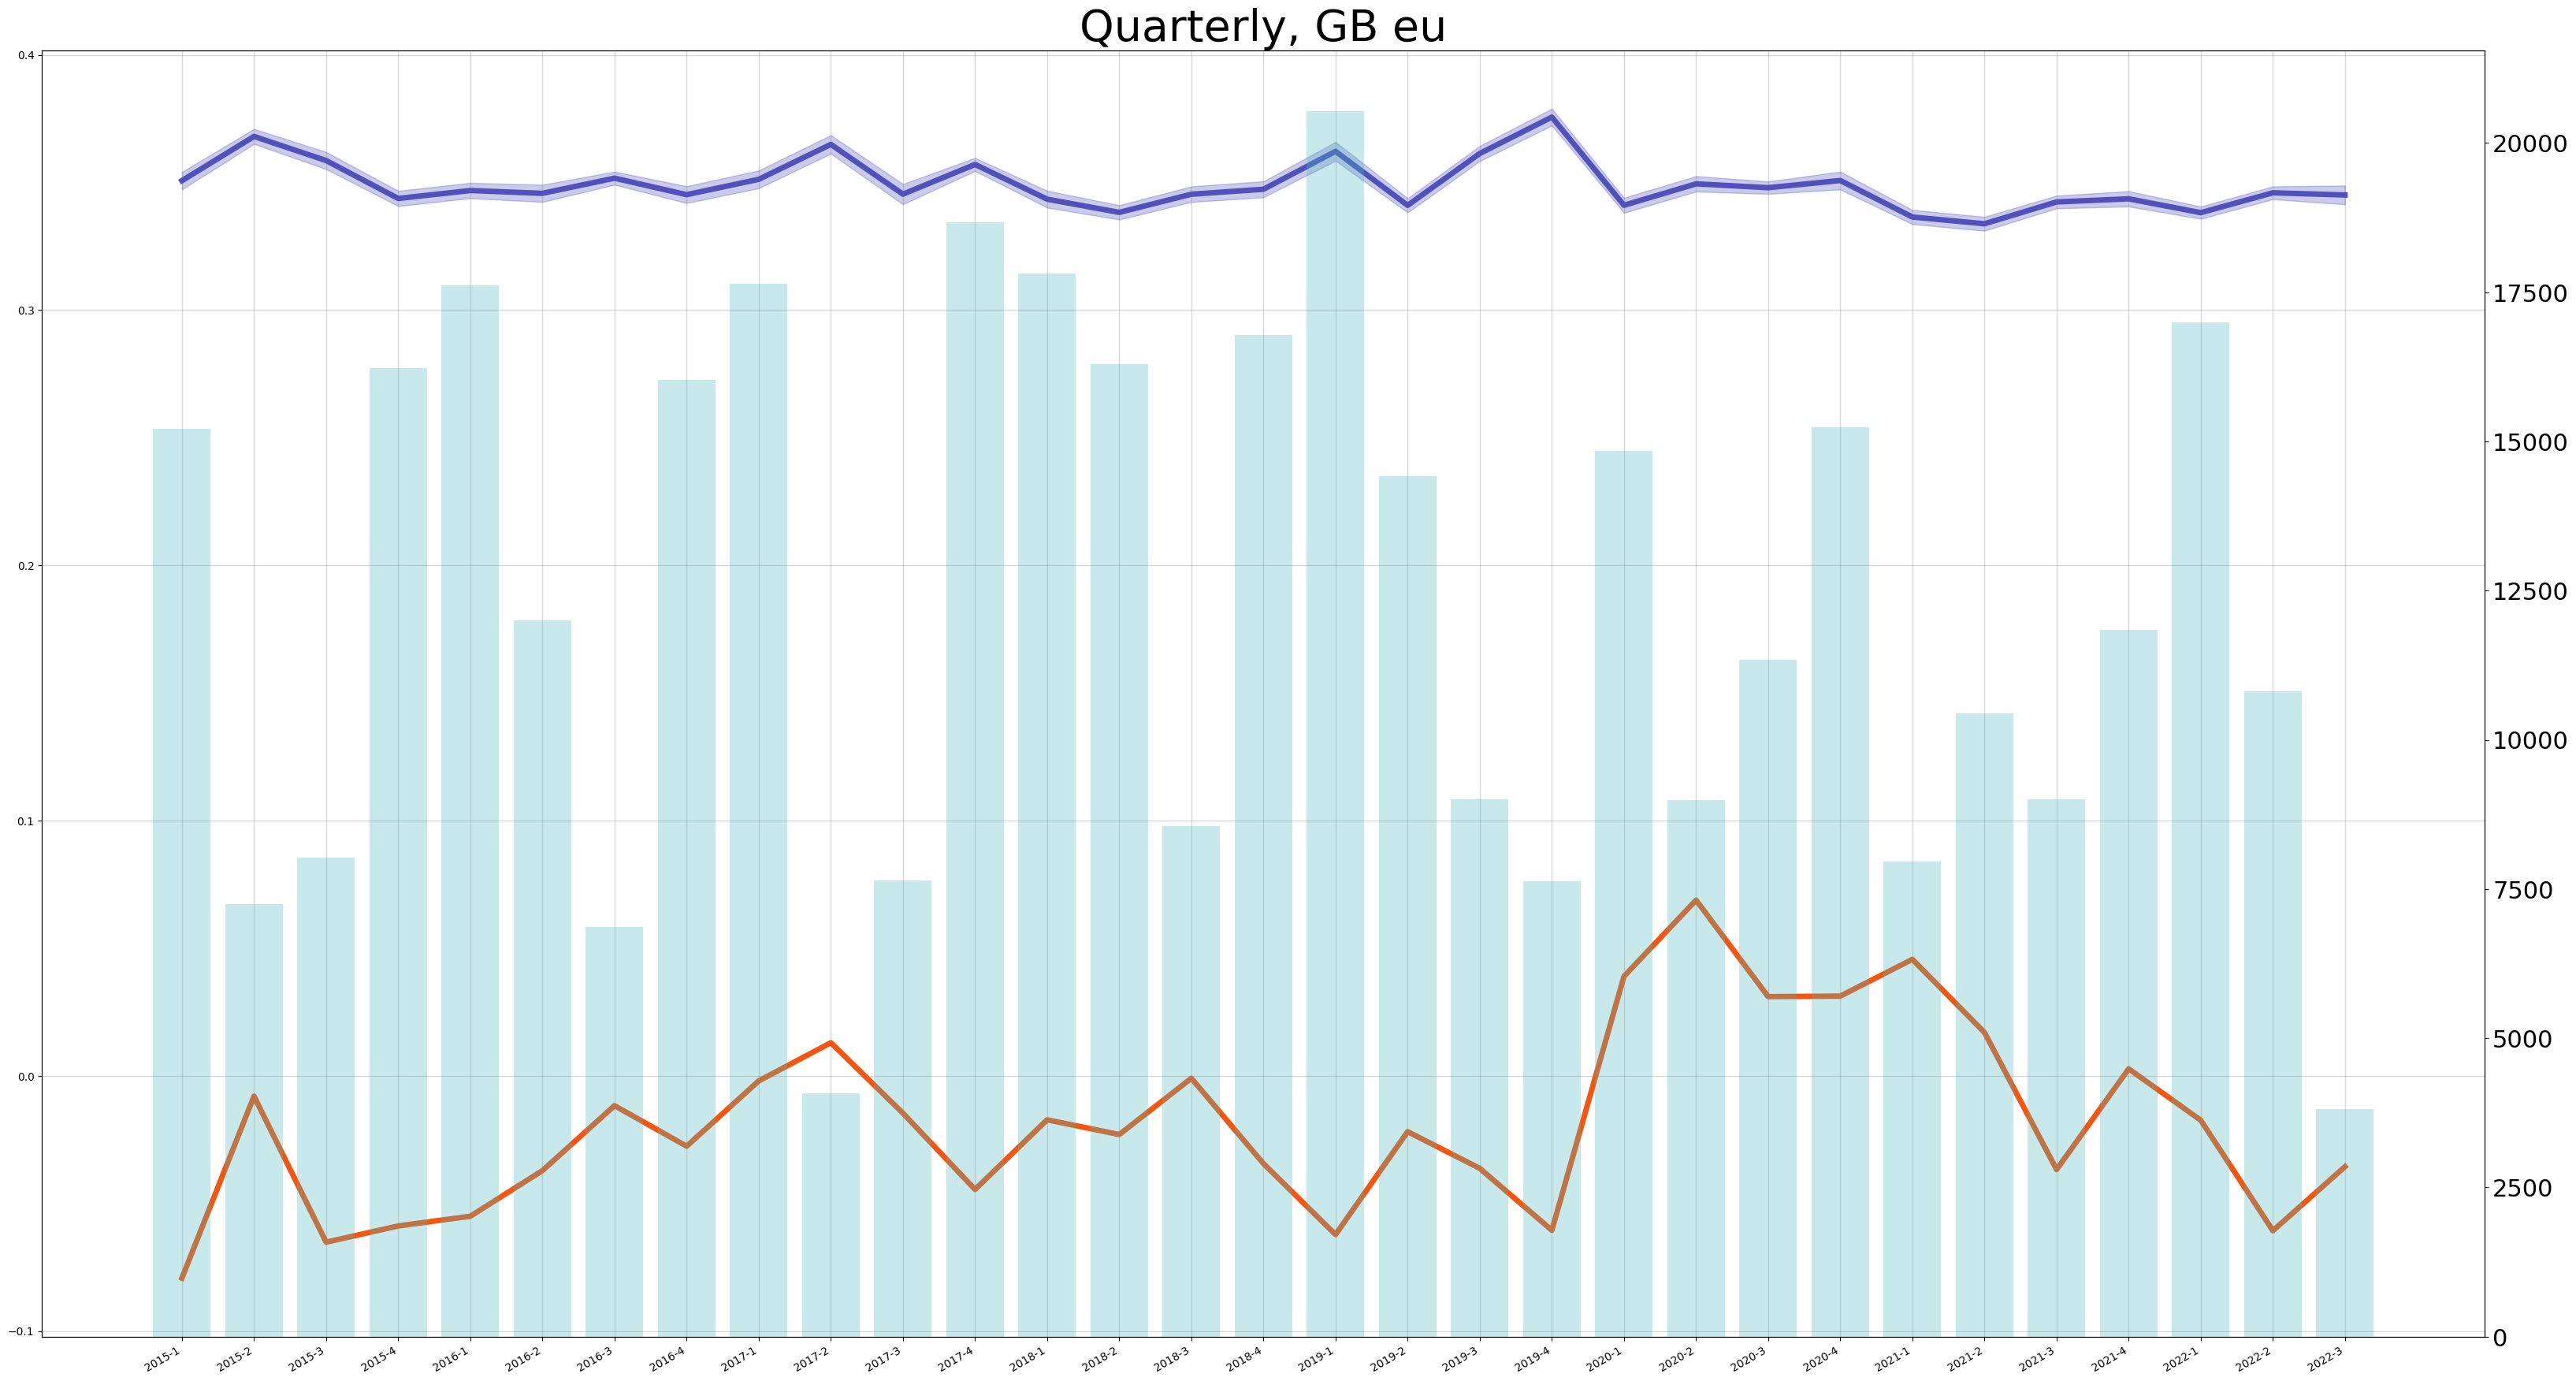

In [332]:

plot_opposition_coalition_time_series(df=stats1, time_period_type='quarter', country='GB', topic='eu', save_path=None, show_plot=True)

### Loop Through Parliaments and Topics and Save DF, Figure

100%|██████████| 31/31 [06:41<00:00, 12.95s/it]


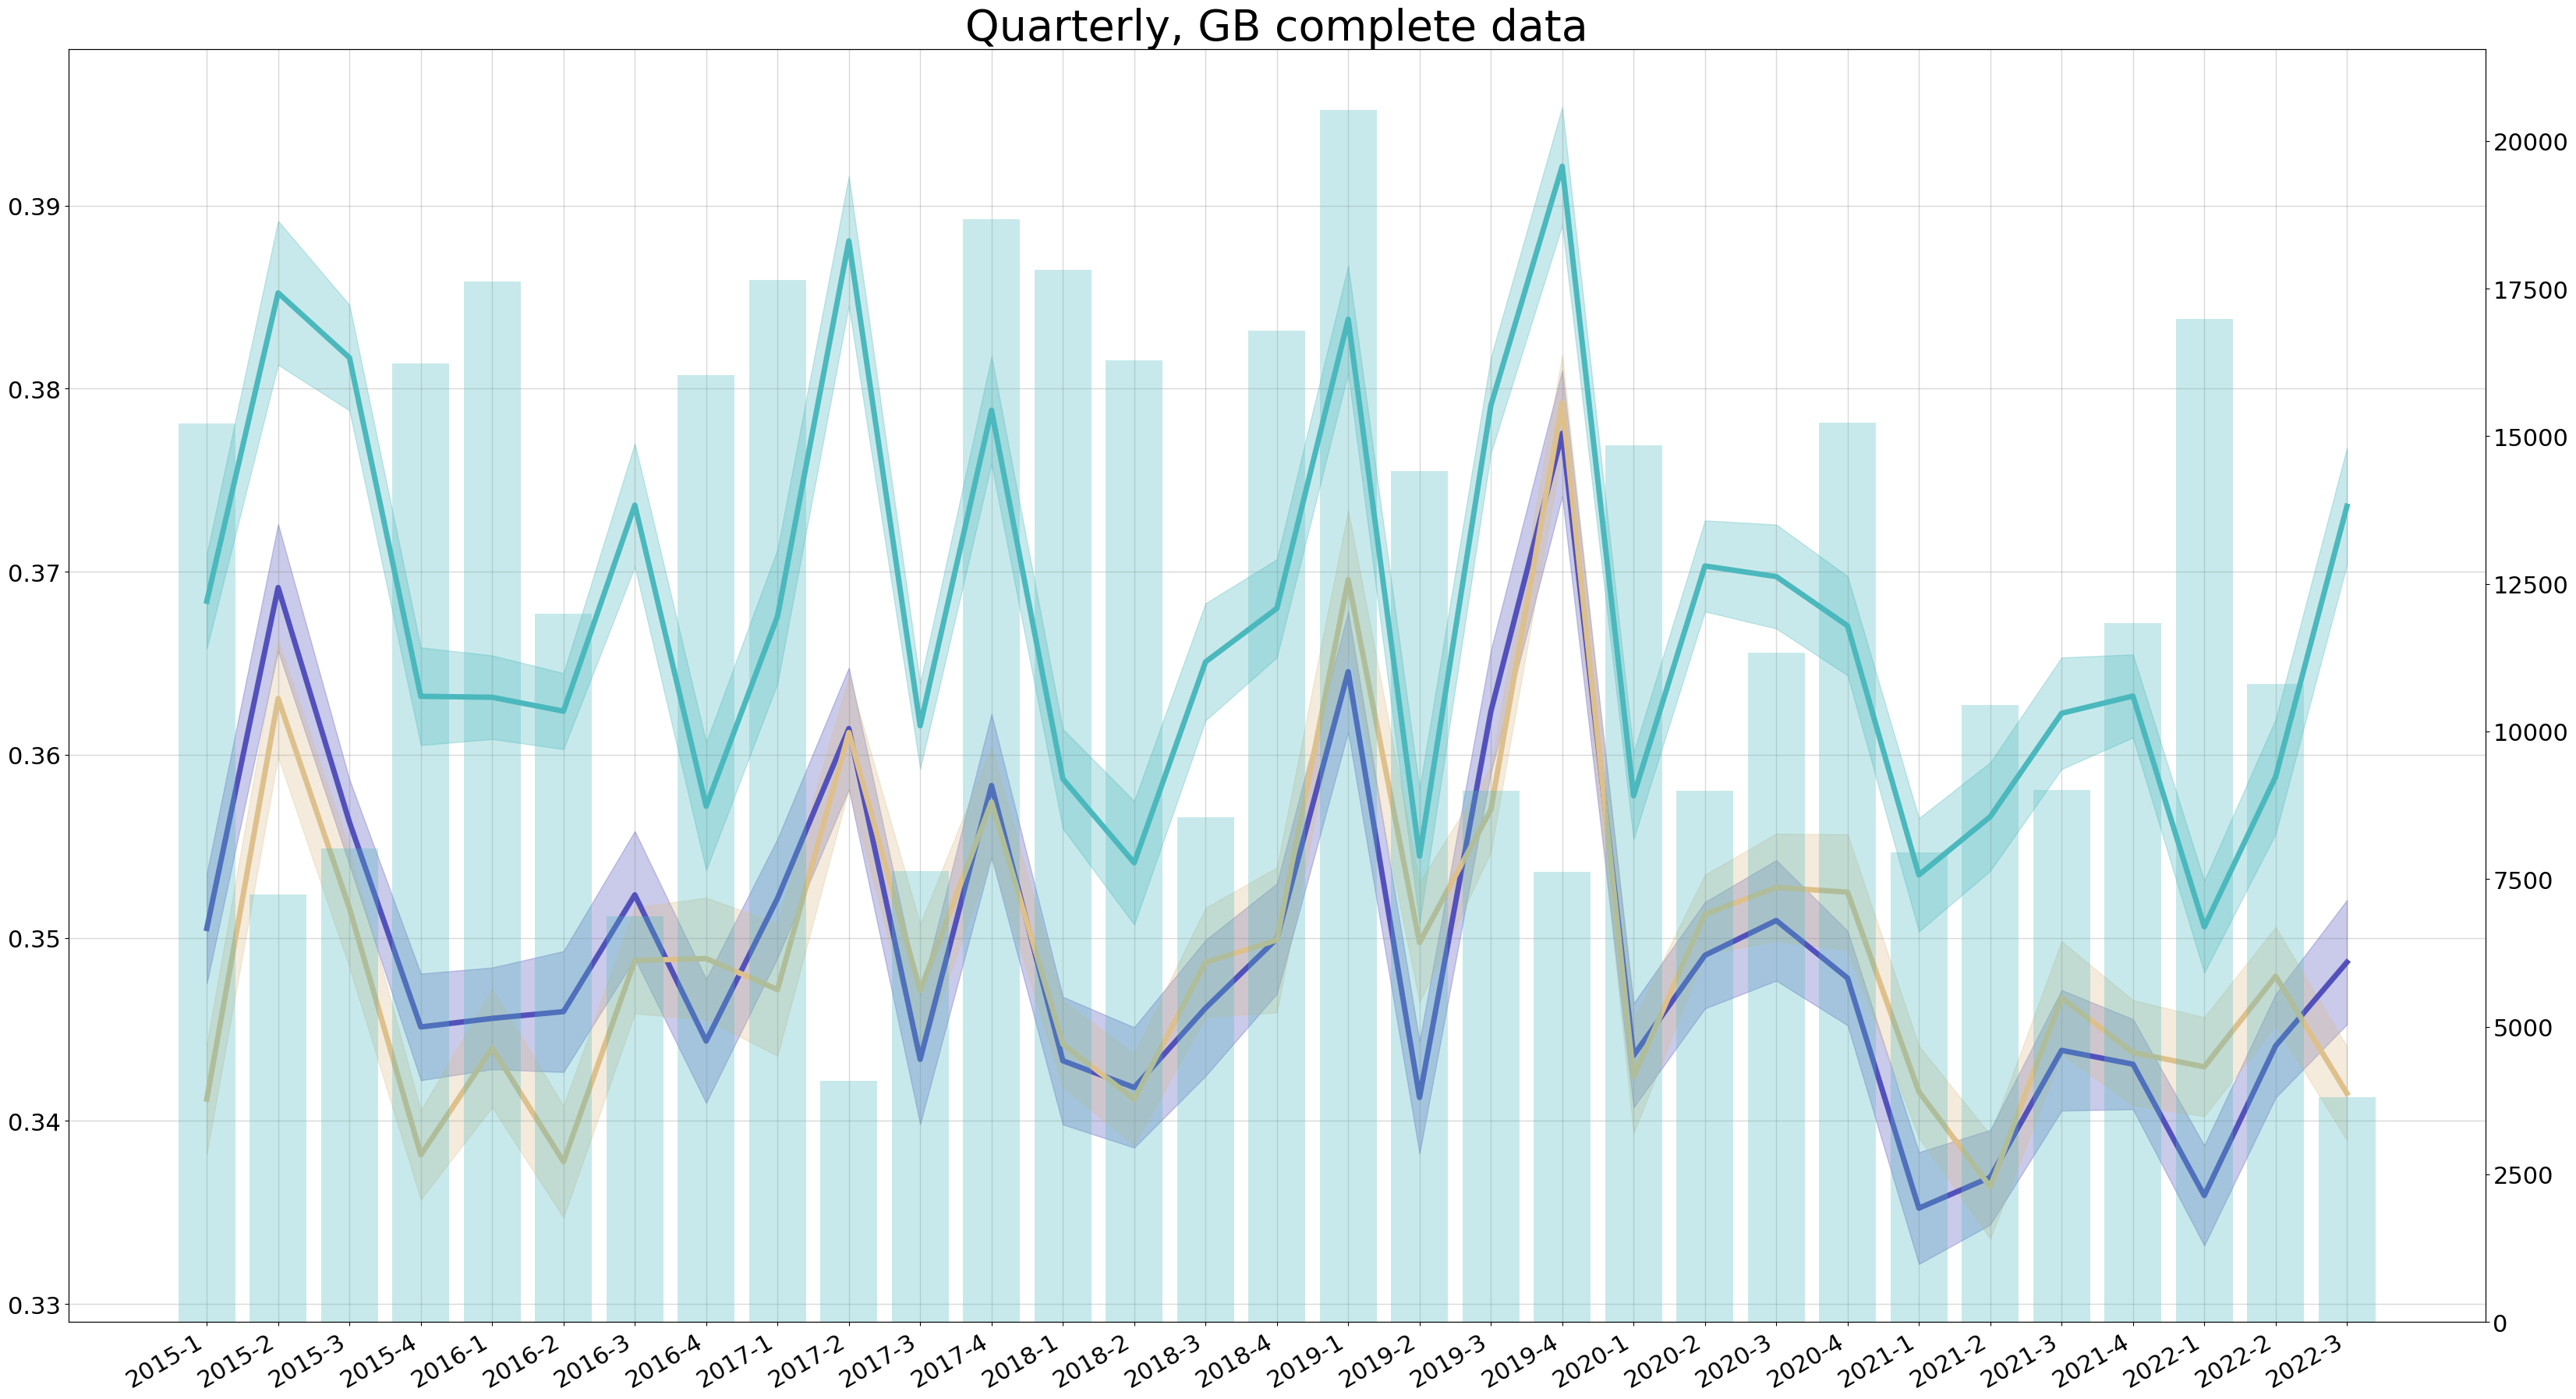

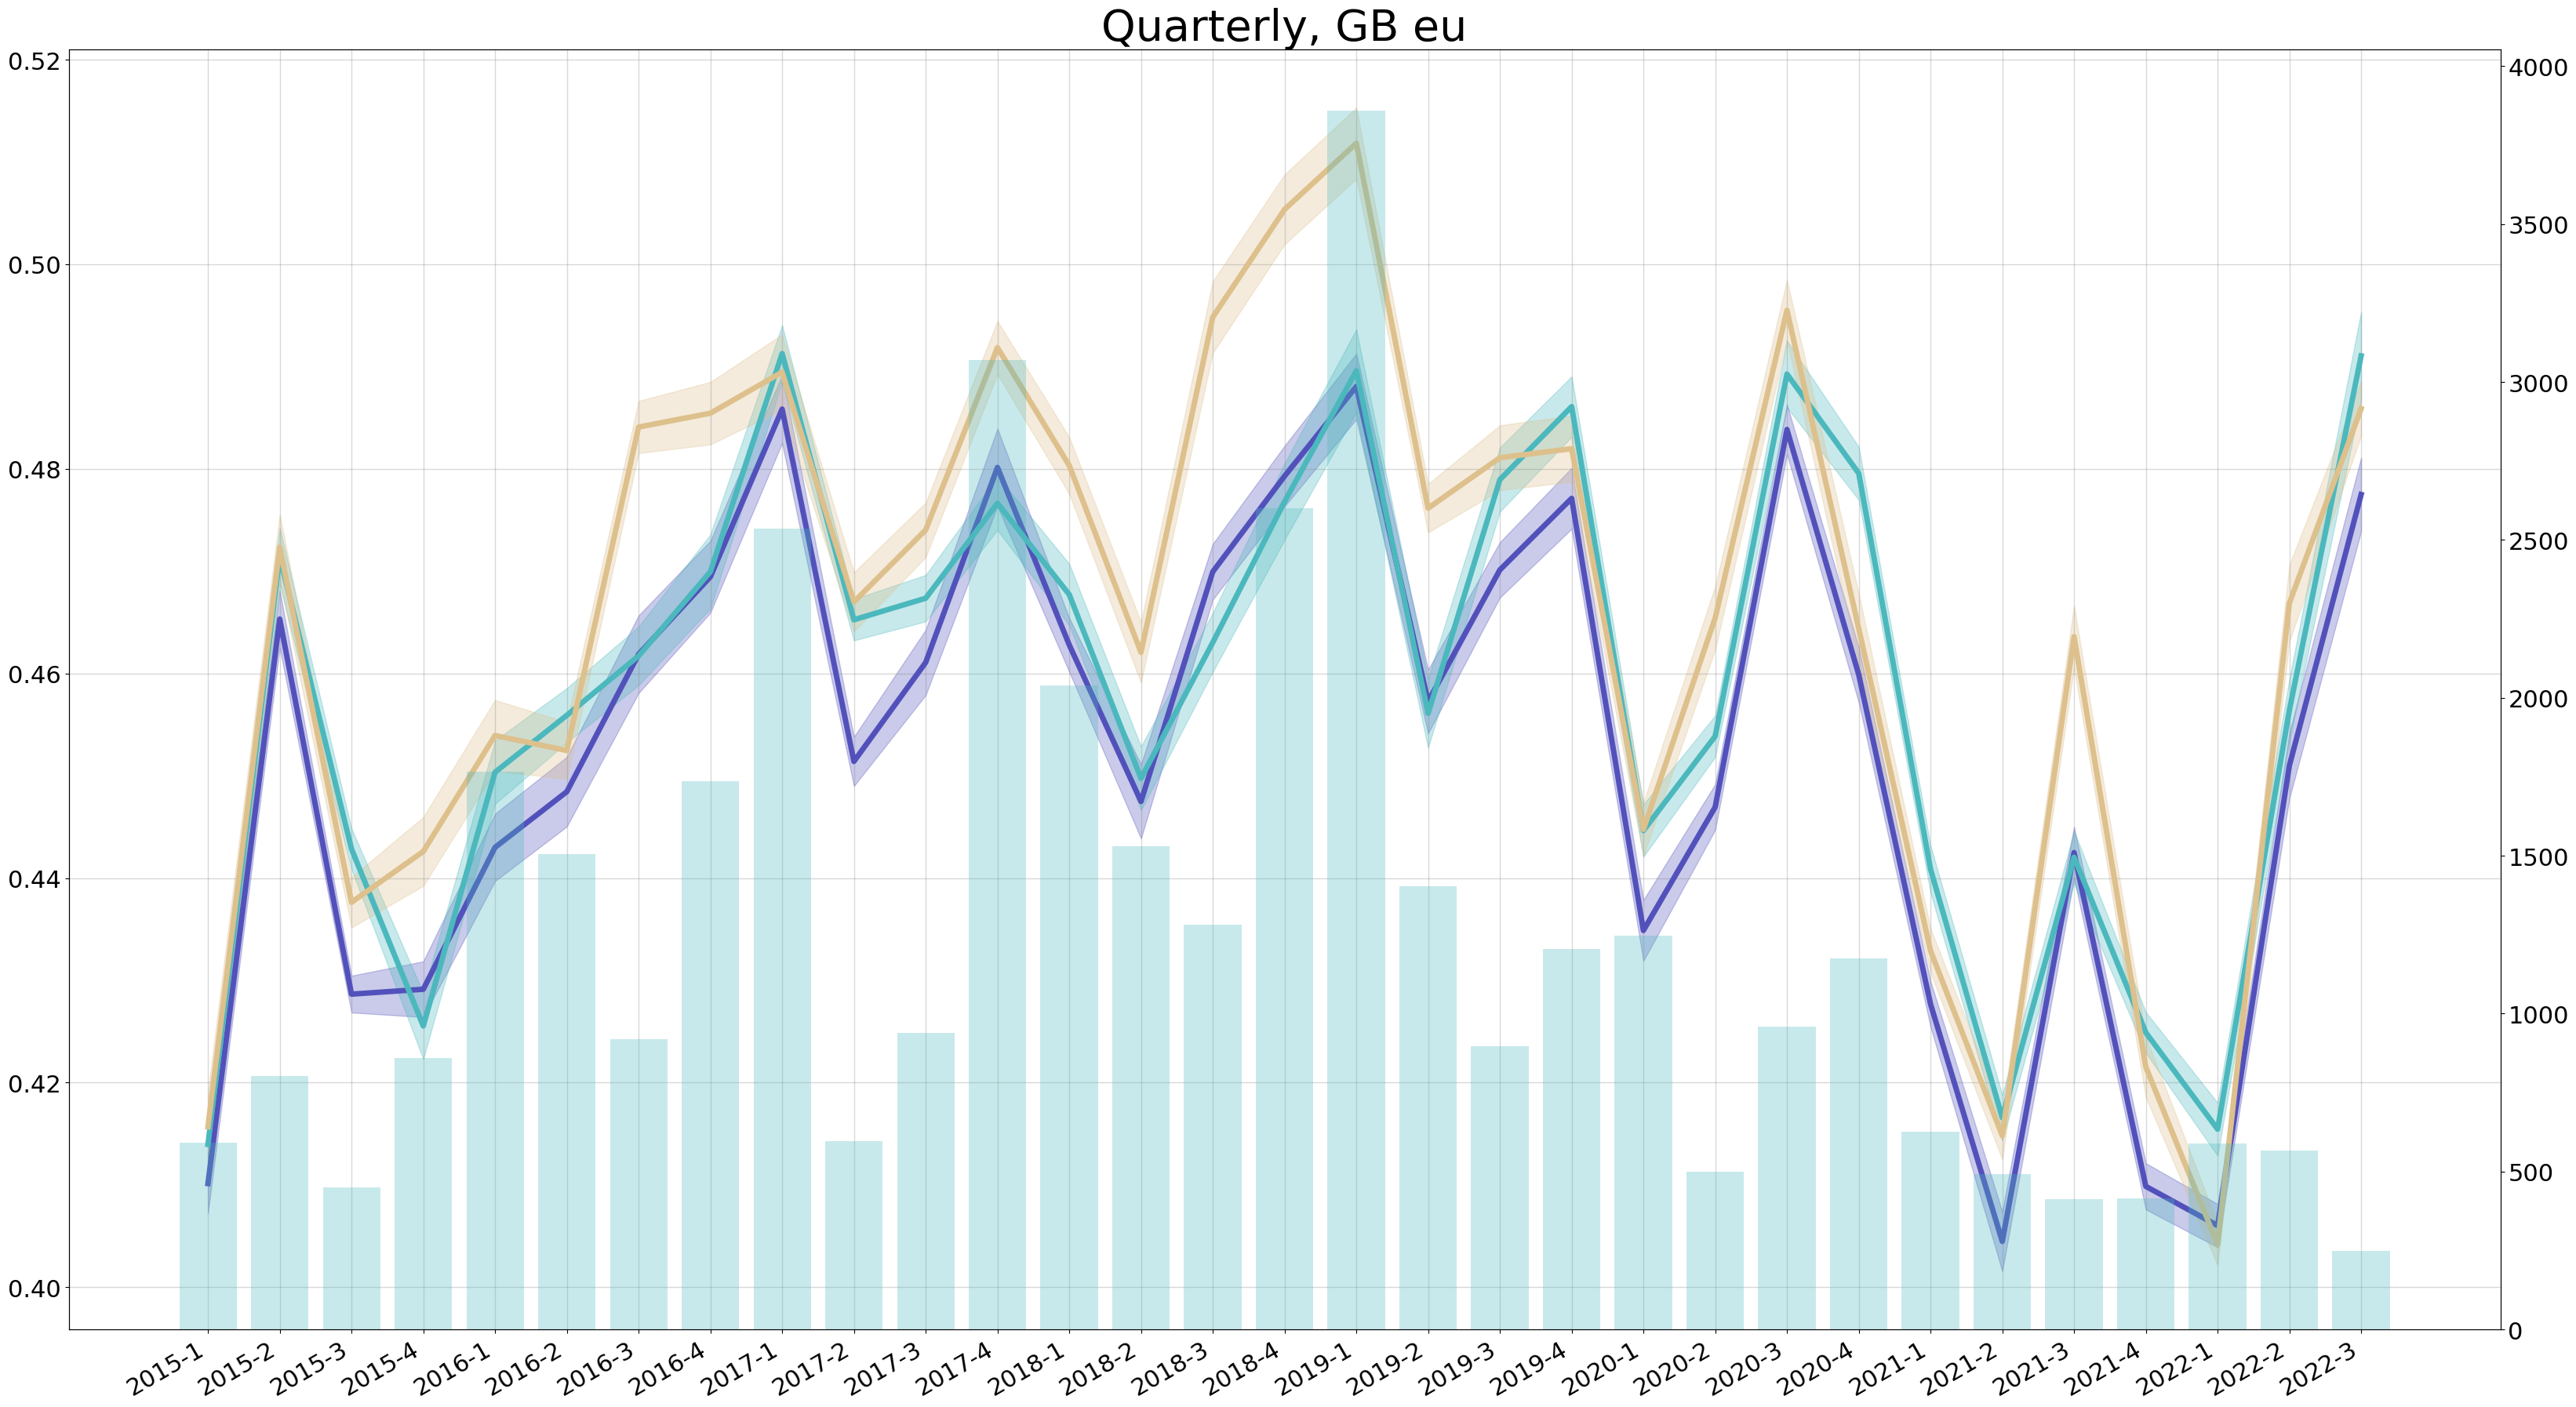

In [419]:
time_period = 'quarter'
country_codes = ['GB']
topics = ['eu']
__location__ = os.path.abspath("")
compute_topics = True

for country in country_codes:

    df, df_embeddings, mergeddf, time_period_numbers = run_analysis(country, time_period, topic=None)
    
    if compute_topics:

        for topic in topics:

            df, df_embeddings, mergeddf, time_period_numbers = run_analysis(country, time_period, topic=topic, df_embeddings=df_embeddings)

        